# XRAY - TRUE - CUSTOM 

## Installing and Importing Libraries

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

import tensorflow as tf
from pathlib import Path

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from sklearn.utils import class_weight 

1 Physical GPUs, 1 Logical GPUs


## Importing Dataset and Data Pre-Processing

In [2]:
data_dir = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY/"
train_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY/train/'
test_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY/test/'
img_width, img_height = 224, 224 
channels = 3
batch_size = 32
# image_arr_size= img_width * img_height * channels

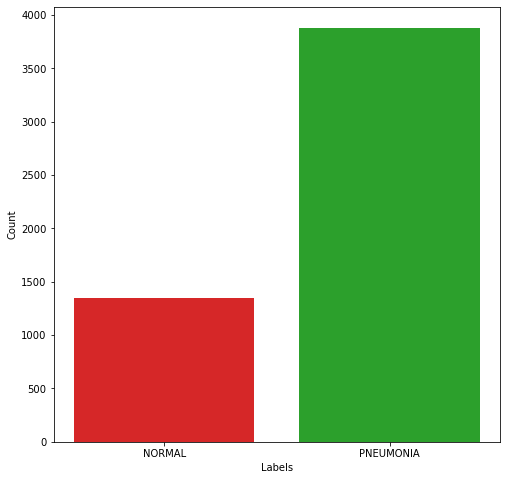

In [3]:
cnv_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
dme_images = len(glob(train_data_dir + 'PNEUMONIA/*.jpeg'))
data= {'NORMAL': cnv_images, 'PNEUMONIA': dme_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Sample Images from the Dataset

Normal


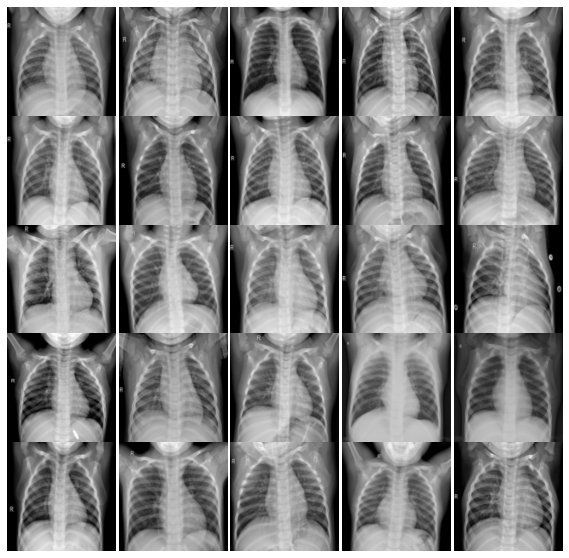

In [4]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  # Remove the CWD from sys.path while we load stuff.


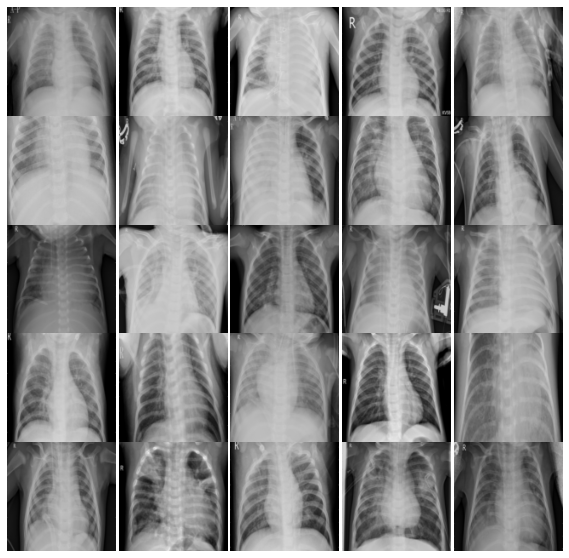

In [5]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/PNEUMONIA/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [6]:
train_datagen = ImageDataGenerator(
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_test_samples = len(test_generator.filenames)

### Image Data Augmentation

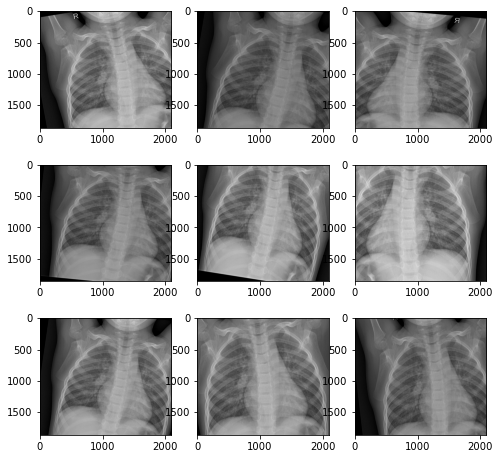

In [9]:
img = load_img(data_dir + 'train/NORMAL/IM-0115-0001.jpeg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0]
	plt.imshow(image.astype('uint8'))

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

# Model
* VGG16 CNN architecture is used for classification.
* Pretrained on the 'ImageNet' dataset.

In [10]:
model = Sequential()
model.add(Conv2D(filters= 32 , kernel_size=(5,5), padding = 'same', activation = 'relu' , input_shape = (img_width, img_height,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

## Baseline Model Training

In [11]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [12]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.75,
    patience=3,
    verbose=1, 
    mode='auto'
)

class_weights = class_weight.compute_class_weight(
       'balanced',
        np.unique(train_generator.classes), 
        train_generator.classes)
class_weights = dict(enumerate(class_weights))

callbacks = [checkpoint, csvlogger,reduceLR]


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [13]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = test_generator, 
    validation_steps = nb_test_samples//batch_size,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True,
    class_weight=class_weights
)

Epoch 1/30
163/163 [==============================] - ETA: 0s - loss: 7.4400 - accuracy: 0.7519
Epoch 00001: val_loss improved from inf to 0.44748, saving model to baseline_model.h5
163/163 [==============================] - 82s 501ms/step - loss: 7.4400 - accuracy: 0.7519 - val_loss: 0.4475 - val_accuracy: 0.8668 - lr: 1.0000e-04
Epoch 2/30
163/163 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8265
Epoch 00002: val_loss improved from 0.44748 to 0.34368, saving model to baseline_model.h5
163/163 [==============================] - 78s 479ms/step - loss: 0.3915 - accuracy: 0.8265 - val_loss: 0.3437 - val_accuracy: 0.8849 - lr: 1.0000e-04
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8552
Epoch 00003: val_loss did not improve from 0.34368
163/163 [==============================] - 78s 479ms/step - loss: 0.3238 - accuracy: 0.8552 - val_loss: 0.4371 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 4/30
163/163 [============

Epoch 28/30
163/163 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9388
Epoch 00028: val_loss did not improve from 0.30676
163/163 [==============================] - 80s 491ms/step - loss: 0.1541 - accuracy: 0.9388 - val_loss: 0.4227 - val_accuracy: 0.8931 - lr: 5.6250e-05
Epoch 29/30
163/163 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.9471
Epoch 00029: val_loss did not improve from 0.30676
163/163 [==============================] - 79s 486ms/step - loss: 0.1343 - accuracy: 0.9471 - val_loss: 0.3776 - val_accuracy: 0.9046 - lr: 5.6250e-05
Epoch 30/30
163/163 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9410
Epoch 00030: val_loss did not improve from 0.30676
163/163 [==============================] - 79s 486ms/step - loss: 0.1541 - accuracy: 0.9410 - val_loss: 0.3616 - val_accuracy: 0.8980 - lr: 5.6250e-05


In [18]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

20/20 [==============================] - 4s 204ms/step - loss: 0.3629 - accuracy: 0.8974
Test Loss:  0.36291801929473877
Test Accuracy:  0.8974359035491943


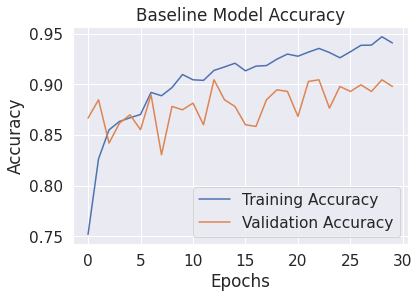

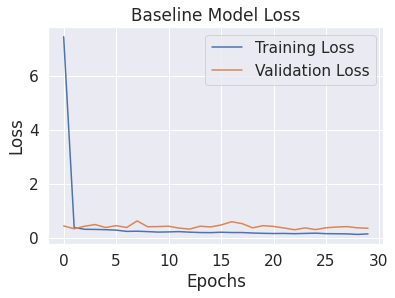

In [19]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

## Evaluations on Test Dataset

In [20]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

20/20 [==============================] - 4s 212ms/step - loss: 0.3629 - accuracy: 0.8974
Test Loss:  0.36291801929473877
Test Accuracy:  0.8974359035491943


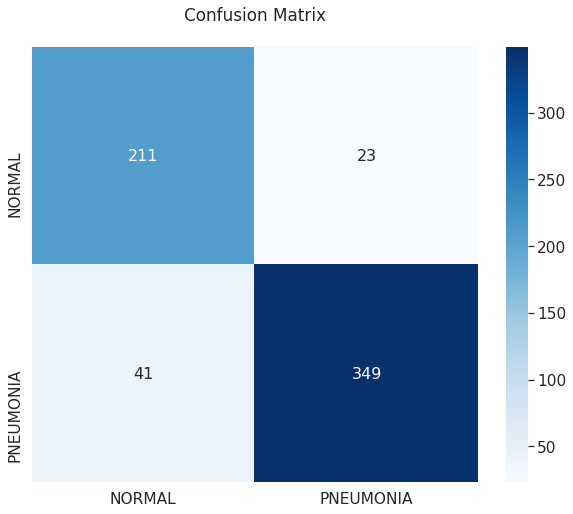

Classification Report

              precision    recall  f1-score   support

      NORMAL       0.84      0.90      0.87       234
   PNEUMONIA       0.94      0.89      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.89       624
weighted avg       0.90      0.90      0.90       624



In [21]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))